In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data & Pre-process

In [2]:
culture_data = pd.read_csv('pretest_analysis_culture_v1.csv')

#Store the top two columns in a dictionary (contains the actual questions associated with each colname)
questions = culture_data.iloc[0:2]
questions.index = ['title','choices']
questions = questions.to_dict()

#Reformat remaining data
culture_data = culture_data.loc[2:] #Include only actual data in the columns 
culture_data.index = range(len(culture_data)) #Reset Index
culture_data.columns = [string.lower() for string in culture_data.columns] #Lowercase all columns (makes loops easier)

#Remove all people who have not finished or have NaN's in all of their rows.
culture_data = culture_data[culture_data['finished'] == 'True']
culture_data = culture_data.fillna(0)
#culture_data = culture_data[culture_data['attention2'] != 0] #filtering out NaN is based on p1

#Removes people who got the gotcha wrong 
culture_data = culture_data[[True if x in ['Strongly agree', 'Agree', 'Somewhat agree',0] else False for x in culture_data['attention1']]]
culture_data = culture_data[[True if x in ['Strongly disagree', 'Disagree', 'Somewhat disagree',0] else False for x in culture_data['attention2']]]

#Filter out rows where avg time per answer is between 1 std of the mean
time_cols = ['p' + str(q) + 'time_page submit' for q in range(1,51)]
for i,col in enumerate(time_cols):
    culture_data[col] = culture_data[col].apply(lambda x: float(x))
    if i == 0:
        culture_data['avg_time'] = culture_data[col]
    else:
        culture_data['avg_time'] = culture_data['avg_time'] + culture_data[col]
culture_data['avg_time'] = culture_data['avg_time'] / len(culture_data)

#Filter out rows where avg time per answer is between 1 std of the mean
time_mean = np.mean(culture_data['avg_time'])
time_std = np.std(culture_data['avg_time'])
culture_data = culture_data[(culture_data['avg_time'] >= time_mean - time_std)]

#Filter out 15 fastest responders (NOTE: MUTUALLY EXCLUSIVE WITH MEAN +/- 1 STD FEATURE)
#culture_data = culture_data.sort_values('avg_time', ascending=False).head(86)

#Filter for policy columns & id columns only
response_cols = ['p' + str(q) + 'agree' for q in range(1,51)]
culture_data = culture_data[['id','polid'] + response_cols]

#Filter out rows where ID's don't begin with 'A'
culture_data = culture_data[culture_data['id'].apply(lambda x: True if x[0] == 'A' else False)]

print(culture_data.shape)
culture_data.head()


(60, 52)


,id,polid,p1agree,p2agree,p3agree,p4agree,p5agree,p6agree,p7agree,p8agree,...,p41agree,p42agree,p43agree,p44agree,p45agree,p46agree,p47agree,p48agree,p49agree,p50agree
0,A70L26UXLTGLC,Republican,Cannot say without more information,Somewhat disagree,Disagree,Agree,Agree,Strongly disagree,Agree,Disagree,...,Disagree,Cannot say without more information,Strongly disagree,Disagree,Strongly agree,Cannot say without more information,Strongly disagree,Strongly disagree,Cannot say without more information,Strongly disagree
1,A35WO79KQ0RF6S,Democrat,Somewhat agree,Somewhat disagree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat disagree,...,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Cannot say without more information,Somewhat agree,Somewhat agree
2,A26XF8O4XRL8JA,Democrat,Strongly disagree,Strongly disagree,Somewhat agree,Somewhat agree,Strongly agree,Strongly disagree,Strongly agree,Somewhat disagree,...,Somewhat disagree,Somewhat disagree,Somewhat disagree,Somewhat agree,Agree,Somewhat disagree,Somewhat disagree,Somewhat disagree,Strongly agree,Somewhat disagree
3,A222AS1V52ZON4,Democrat,Cannot say without more information,Somewhat agree,Somewhat disagree,Strongly disagree,Strongly disagree,Agree,Strongly agree,Strongly disagree,...,Strongly agree,Cannot say without more information,Somewhat agree,Strongly disagree,Strongly agree,Cannot say without more information,Somewhat disagree,Agree,Strongly agree,Somewhat disagree
4,A1ZE0MLGKWQLM8,Democrat,Somewhat disagree,Cannot say without more information,Cannot say without more information,Somewhat disagree,Strongly agree,Strongly disagree,Somewhat disagree,Somewhat disagree,...,Strongly agree,Cannot say without more information,Somewhat agree,Somewhat agree,Somewhat agree,Agree,Somewhat agree,Somewhat disagree,Strongly agree,Strongly disagree


In [3]:
#Get party without ideology
culture_data['ptyid'] = culture_data['polid'].apply(lambda x: 'r' if 'Republican' in x else ('d' if 'Democrat' in x else 'o'))

#Turn everything into likert scales
culture_data['polid'] = culture_data['polid'].map({'Republican':-2, 'Lean Republican': -1, 
                              'Independent/Other/Neither':0,
                              'Lean Democratic':1, 'Democrat':2})
for col in response_cols:
    culture_data[col] = culture_data[col].map({'Strongly agree':-3, 'Agree':-2, 'Somewhat agree': -1, 
                                            'Cannot say without more information':0,
                                            'Somewhat disagree': 1, 'Disagree': 2, 'Strongly disagree': 3})

culture_data.head()

,id,polid,p1agree,p2agree,p3agree,p4agree,p5agree,p6agree,p7agree,p8agree,...,p42agree,p43agree,p44agree,p45agree,p46agree,p47agree,p48agree,p49agree,p50agree,ptyid
0,A70L26UXLTGLC,-2,0,1,2,-2,-2,3,-2,2,...,0,3,2,-3,0,3,3,0,3,r
1,A35WO79KQ0RF6S,2,-1,1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,0,-1,-1,d
2,A26XF8O4XRL8JA,2,3,3,-1,-1,-3,3,-3,1,...,1,1,-1,-2,1,1,1,-3,1,d
3,A222AS1V52ZON4,2,0,-1,1,3,3,-2,-3,3,...,0,-1,3,-3,0,1,-2,-3,1,d
4,A1ZE0MLGKWQLM8,2,1,0,0,1,-3,3,1,1,...,0,-1,-1,-1,-2,-1,1,-3,3,d


## Get Means of both Parties & Combined for each item

In [4]:
#Isolate Republican & Democrat Data
r_data = culture_data[culture_data['ptyid'] == 'r']
d_data = culture_data[culture_data['ptyid'] == 'd']

#Get Means and STD's by party/combined
party_means = pd.DataFrame((culture_data.mean()).rename('all')).join(
                            (r_data.mean()).rename('rep')).join(
                            (d_data.mean()).rename('dem'))

party_std = pd.DataFrame((culture_data.std()).rename('all')).join(
                            (r_data.std()).rename('rep')).join(
                            (d_data.std()).rename('dem'))

party_means.head()

,all,rep,dem
polid,0.150000,-1.615385,1.758621
p1agree,0.466667,0.807692,0.068966
p2agree,0.166667,0.384615,0.068966
p3agree,-0.116667,-0.923077,0.551724
p4agree,-0.200000,-0.384615,-0.034483


/Users/ctt45/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


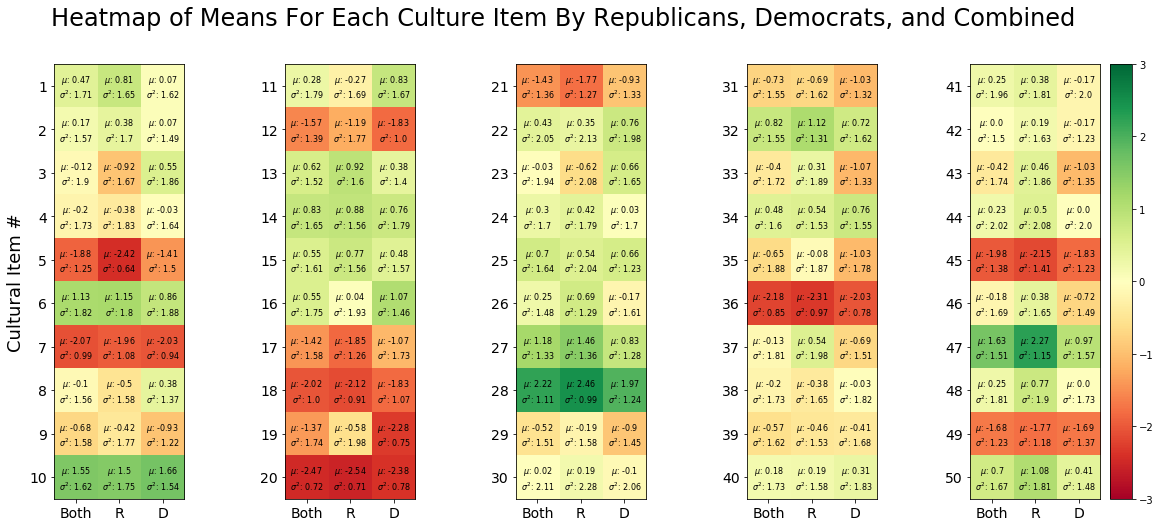

In [26]:
#Generate Heatmap of each cultural item by party/combined & mean/std 
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5)
fig.set_size_inches(20,8)

ax1.imshow(party_means.iloc[1:11],cmap='RdYlGn',vmin=-3, vmax=3)
ax2.imshow(party_means.iloc[11:21],cmap='RdYlGn',vmin=-3, vmax=3)
ax3.imshow(party_means.iloc[21:31],cmap='RdYlGn',vmin=-3, vmax=3)
ax4.imshow(party_means.iloc[31:41],cmap='RdYlGn',vmin=-3, vmax=3)
hm=ax5.imshow(party_means.iloc[41:51],cmap='RdYlGn',vmin=-3, vmax=3)

for cnt,ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(np.arange(10*cnt+1,11+(10*cnt+1)), size=14)
    ax.set_xticklabels(['','Both','R','D'], size=14)

    
ax1.set_ylabel('Cultural Item #',size=18)
#hm.set_clim(vmin=-3, vmax=3)
fig.colorbar(hm, orientation='vertical')
fig.suptitle('Heatmap of Means For Each Culture Item By Republicans, Democrats, and Combined\n', size=24)

for axnum,ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    labels = party_means.iloc[10*axnum+1:10+(10*axnum+1)]
    for j,idx in enumerate(labels.index):
        for i,col in enumerate(labels.columns):
            #text = round(labels.loc[idx,col],2)           
            text = '$\mu$: '  + str(round(labels.loc[idx,col],2)) + '\n'
            text = text + '$\sigma^2$: ' + str(round(party_std.loc[idx,col],2))
            ax.text(i, j, text, ha="center", va="center", color="k", size=8)


fig.show()
fig.savefig('culture_party_meanstd_visual.png', dpi=600)

# Get Correlations of between ideology & cultural items

In [12]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

#Generate 
coor_data = pd.DataFrame([pearsonr(culture_data['polid'],culture_data[col])[0] for col in response_cols],
                                 columns=['pearsonr'])
coor_data = coor_data.join(pd.DataFrame([spearmanr(culture_data['polid'],culture_data[col])[0] for col in response_cols],
                                 columns=['spearmanr']))

coor_data.index = response_cols
coor_data.head()

,pearsonr,spearmanr
p1agree,-0.277205,-0.294419
p2agree,-0.156420,-0.164239
p3agree,0.397918,0.389560
p4agree,0.097914,0.108267
p5agree,0.385710,0.387845


/Users/ctt45/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


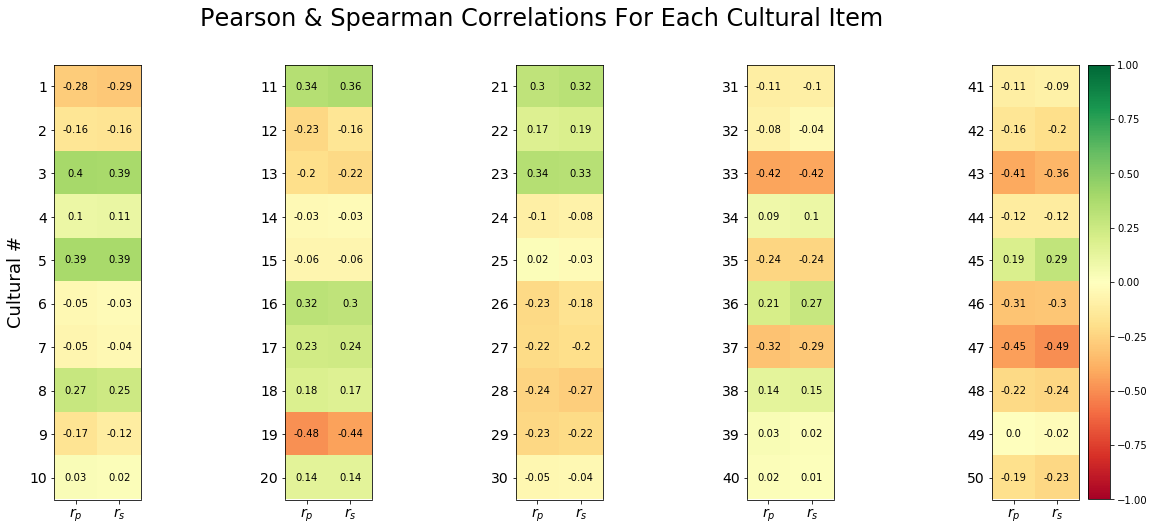

In [25]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5)
fig.set_size_inches(20,8)

ax1.imshow(coor_data.iloc[0:10],cmap='RdYlGn',vmin=-1, vmax=1)
ax2.imshow(coor_data.iloc[10:20],cmap='RdYlGn',vmin=-1, vmax=1)
ax3.imshow(coor_data.iloc[20:30],cmap='RdYlGn',vmin=-1, vmax=1)
ax4.imshow(coor_data.iloc[30:40],cmap='RdYlGn',vmin=-1, vmax=1)
hm=ax5.imshow(coor_data.iloc[40:50],cmap='RdYlGn',vmin=-1, vmax=1)

for cnt,ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(np.arange(10*cnt+1,11+(10*cnt+1)), size=14)
    ax.set_xticklabels(['','$r_p$', '$r_s$'], size=14)

ax1.set_ylabel('Cultural #',size=18)
#hm.set_clim(vmin=-3, vmax=3)
fig.colorbar(hm, orientation='vertical')
fig.suptitle('Pearson & Spearman Correlations For Each Cultural Item\n', size=24)

for axnum,ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    labels = coor_data.iloc[10*axnum:10+(10*axnum)]
    for j,idx in enumerate(labels.index):
        for i,col in enumerate(labels.columns):
            #text = round(labels.loc[idx,col],2)           
            text = round(labels.loc[idx,col],2)
            ax.text(i, j, text, ha="center", va="center", color="k")

fig.show()
fig.savefig('culture__party_rvalues_visual.png', dpi=600)

# Build a Histogram of each Cultural Item by party

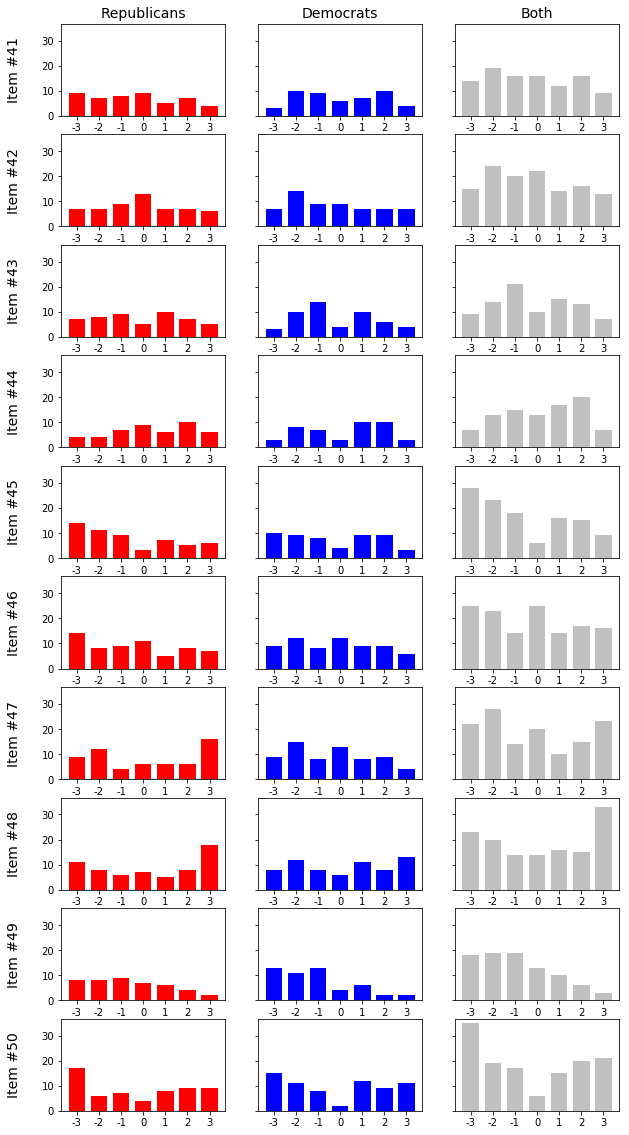

In [24]:
#Generate histogram distributions of each Cultural Item position, where x-axis = agree choice
r_data = culture_data[culture_data['ptyid'] == 'r']
d_data = culture_data[culture_data['ptyid'] == 'd']

fig, axarr = plt.subplots(10,3,sharey=True)
fig.set_size_inches(10,20)

for start,finish in [(0,10),(10,20),(20,30),(30,40),(40,50)]:
    for i,polcol in enumerate(response_cols[start:finish]):
        axarr[i,0].hist(r_data[polcol], bins=[-3,-2,-1,0,1,2,3,4], align='left', rwidth=.75, color='r')
        axarr[i,1].hist(d_data[polcol], bins=[-3,-2,-1,0,1,2,3,4], align='left', rwidth=.75, color='b')
        axarr[i,2].hist(culture_data[polcol], bins=[-3,-2,-1,0,1,2,3,4], align='left', rwidth=.75, color='silver')

        for j in range(3):
            axarr[i,j].set_xticks(np.arange(-3,4))
            axarr[i,j].set_xticklabels(np.arange(-3,4))

        axarr[i,0].set_ylabel('Item #' + str(i+1+start)  + '\n', size=14)

    axarr[0,0].set_title('Republicans', size=14)
    axarr[0,1].set_title('Democrats', size=14)
    axarr[0,2].set_title('Both', size=14)

    fig.savefig('culture_party_hist_visual_'+ str(start) + '_' + str(finish) + '.png', dpi=600)

# Generate CSV for Michael

In [27]:
#Re-generate correlation matrix 
corr_data = pd.DataFrame([pearsonr(culture_data['polid'],culture_data[col])[0] for col in response_cols],
                                 columns=['pearsonr'])
corr_data = corr_data.join(pd.DataFrame([spearmanr(culture_data['polid'],culture_data[col])[0] for col in response_cols],
                                 columns=['spearmanr']))
corr_data.index = response_cols

#Combine mean & std dfs (Copied from previous code, excuse the ugliness)
csv_data = party_means.copy()
csv_data.columns = ['all_mean','rep_mean','dem_mean']
csv_data = csv_data.join(party_std.copy())
csv_data.columns = ['all_mean','rep_mean','dem_mean'] + ['all_std','rep_std','dem_std']

#Combine the correlation matrix and calculate errors
new_csv_data = csv_data.iloc[1:].join(corr_data)[['all_mean','all_std','spearmanr']]
new_csv_data['all_std'] = new_csv_data['all_std']/(len(culture_data)**0.5) #Turn std into standard error
new_csv_data['spearmanr_se'] = [0] * len(new_csv_data) #Generate SE of estimate column (filled in next cell)
new_csv_data = new_csv_data.reset_index()
new_csv_data.columns = ['name','mean','se_mean','spearmanr','se_estimate']

new_csv_data

,name,mean,se_mean,spearmanr,se_estimate
0,p1agree,0.466667,0.221023,-0.294419,0
1,p2agree,0.166667,0.203315,-0.164239,0
2,p3agree,-0.116667,0.244824,0.389560,0
3,p4agree,-0.200000,0.222721,0.108267,0
4,p5agree,-1.883333,0.161371,0.387845,0
5,p6agree,1.133333,0.234661,-0.027418,0
6,p7agree,-2.066667,0.127706,-0.040744,0
7,p8agree,-0.100000,0.201267,0.249316,0
8,p9agree,-0.683333,0.203766,-0.117172,0
9,p10agree,1.550000,0.209148,0.019108,0


In [28]:
#Get SE of estimate
from scipy.stats import rankdata
from scipy.stats import linregress

id_data = rankdata(culture_data['polid'],'dense')
for i,col in enumerate(new_csv_data['name']):
    cultitem = rankdata(culture_data[col],'dense')
    new_csv_data.loc[i,'se_estimate'] = linregress(id_data,cultitem)[4]
    
#Save as .csv
new_csv_data.to_csv('culture_pretest_summary_data_60.csv')
new_csv_data

,name,mean,se_mean,spearmanr,se_estimate
0,p1agree,0.466667,0.221023,-0.294419,0.128133
1,p2agree,0.166667,0.203315,-0.164239,0.121165
2,p3agree,-0.116667,0.244824,0.389560,0.135522
3,p4agree,-0.200000,0.222721,0.108267,0.133738
4,p5agree,-1.883333,0.161371,0.387845,0.089832
5,p6agree,1.133333,0.234661,-0.027418,0.141443
6,p7agree,-2.066667,0.127706,-0.040744,0.076938
7,p8agree,-0.100000,0.201267,0.249316,0.116921
8,p9agree,-0.683333,0.203766,-0.117172,0.121135
9,p10agree,1.550000,0.209148,0.019108,0.126154
